
# 环境配置

In [ ]:
# !nvidia-smi
import torch
print(torch.__version__)
torch.cuda.set_device(0)

2.0.1+cu118


In [ ]:
# 连接网盘
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
%cd drive/MyDrive/detectron2
%ls

/content/drive/MyDrive/detectron2
 018_Color.png                              output2.mp4
 1.jpg                                      output_cut.mp4
 3.jpg                                      panopticapi/
 balloon/                                   panoptic_images/
 balloon_dataset.zip                        path_to_output_video.mp4
 bean/                                      plant/
 bean_masks/                                plant_002.jpg
 bean_set/                                  plant_009.jpg
 box_disease/                               plant_015.jpg
 coco_eval/                                 plant1.mp4
 color2.png                                 plant_output.mp4
 cow/                                       plant_output_video.mp4
 detectron2_dc/                             pre.jpg
 field/                                     road/
 field.mp4                                  RoadDataset/
 image_visual_final.mp4                     road_output/
 img_18.png                             

In [ ]:
# !pip install pyyaml==5.1
# !python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.10/index.html
!pip install opencv-python opencv-python-headless
# !python -m pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-0_aa5qrh
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-0_aa5qrh
  Resolved https://github.com/facebookresearch/detectron2.git to commit 80307d2d5e06f06a8a677cc2653f23a4c56402ac
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6112288 sha256=1970892881815926cf0e140b5888913d

# 目标检测训练过程

In [ ]:
import os
import numpy as np
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data.datasets import register_coco_instances
from detectron2 import model_zoo

## 注册训练集

In [ ]:
register_coco_instances("plant_train", {}, "./bean_set/plant-train1/dataset.json", "./bean_set/plant-train1")

## 配置模型并训练

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")) #配置预训练模型
cfg.DATASETS.TRAIN = ("plant_train",) # 配置训练集
cfg.DATASETS.TEST = () # 配置测试集
cfg.DATALOADER.NUM_WORKERS = 2 # 线程数
cfg.SOLVER.IMS_PER_BATCH = 2 # 每次迭代的图像数量
cfg.SOLVER.BASE_LR = 0.00025 # 初始学习率
cfg.SOLVER.MAX_ITER = 100 # 训练迭代次数
cfg.SOLVER.STEPS = [] # 学习率的下降策略
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 # 每张训练的ROI数量
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 根据实际类别数量修改
cfg.OUTPUT_DIR = './output/plant_object_fpn_R_50_1x_100' # 模型输出保存路径


In [ ]:
# 训练器定义
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False) # 是否继承上一次训练的参数，在自己的output里面
trainer.train()


[09/05 08:37:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

R-50.pkl: 102MB [00:00, 139MB/s]                            

[09/05 08:37:47 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......


[09/05 08:37:47 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint      | Shapes                                          |
|:------------------|:-------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w} | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.conv3.*    | res2_1_branch2c_{bn_*,w} | (256,) (256,) (256,) (256,) (256,64,1,1)        |

backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
  fc1000.{bias, weight}
  stem.conv1.bias


[09/05 08:37:47 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[09/05 08:38:01 d2.utils.events]:  eta: 0:00:39  iter: 19  total_loss: 1.086  loss_cls: 0.3755  loss_box_reg: 0.0003629  loss_rpn_cls: 0.7054  loss_rpn_loc: 0.005468    time: 0.5028  last_time: 0.4533  data_time: 0.0649  last_data_time: 0.0169   lr: 4.7703e-05  max_mem: 2544M
[09/05 08:38:14 d2.utils.events]:  eta: 0:00:30  iter: 39  total_loss: 0.6704  loss_cls: 0.02498  loss_box_reg: 0.0003208  loss_rpn_cls: 0.6323  loss_rpn_loc: 0.00592    time: 0.5012  last_time: 0.5138  data_time: 0.0084  last_data_time: 0.0056   lr: 9.7653e-05  max_mem: 2544M
[09/05 08:38:24 d2.utils.events]:  eta: 0:00:19  iter: 59  total_loss: 0.6022  loss_cls: 0.05505  loss_box_reg: 0.02596  loss_rpn_cls: 0.4943  loss_rpn_loc: 0.005186    time: 0.4921  last_time: 0.4136  data_time: 0.0077  last_data_time: 0.0053   lr: 0.0001476  max_mem: 2544M
[09/05 08:38:34 d2.utils.events]:  eta: 0:00:09  iter: 79  total_loss: 0.4309  loss_cls: 0.06767  loss_box_reg: 0.04426  loss_rpn_cls: 0.3122  loss_rpn_loc: 0.006943    

## 预测图片

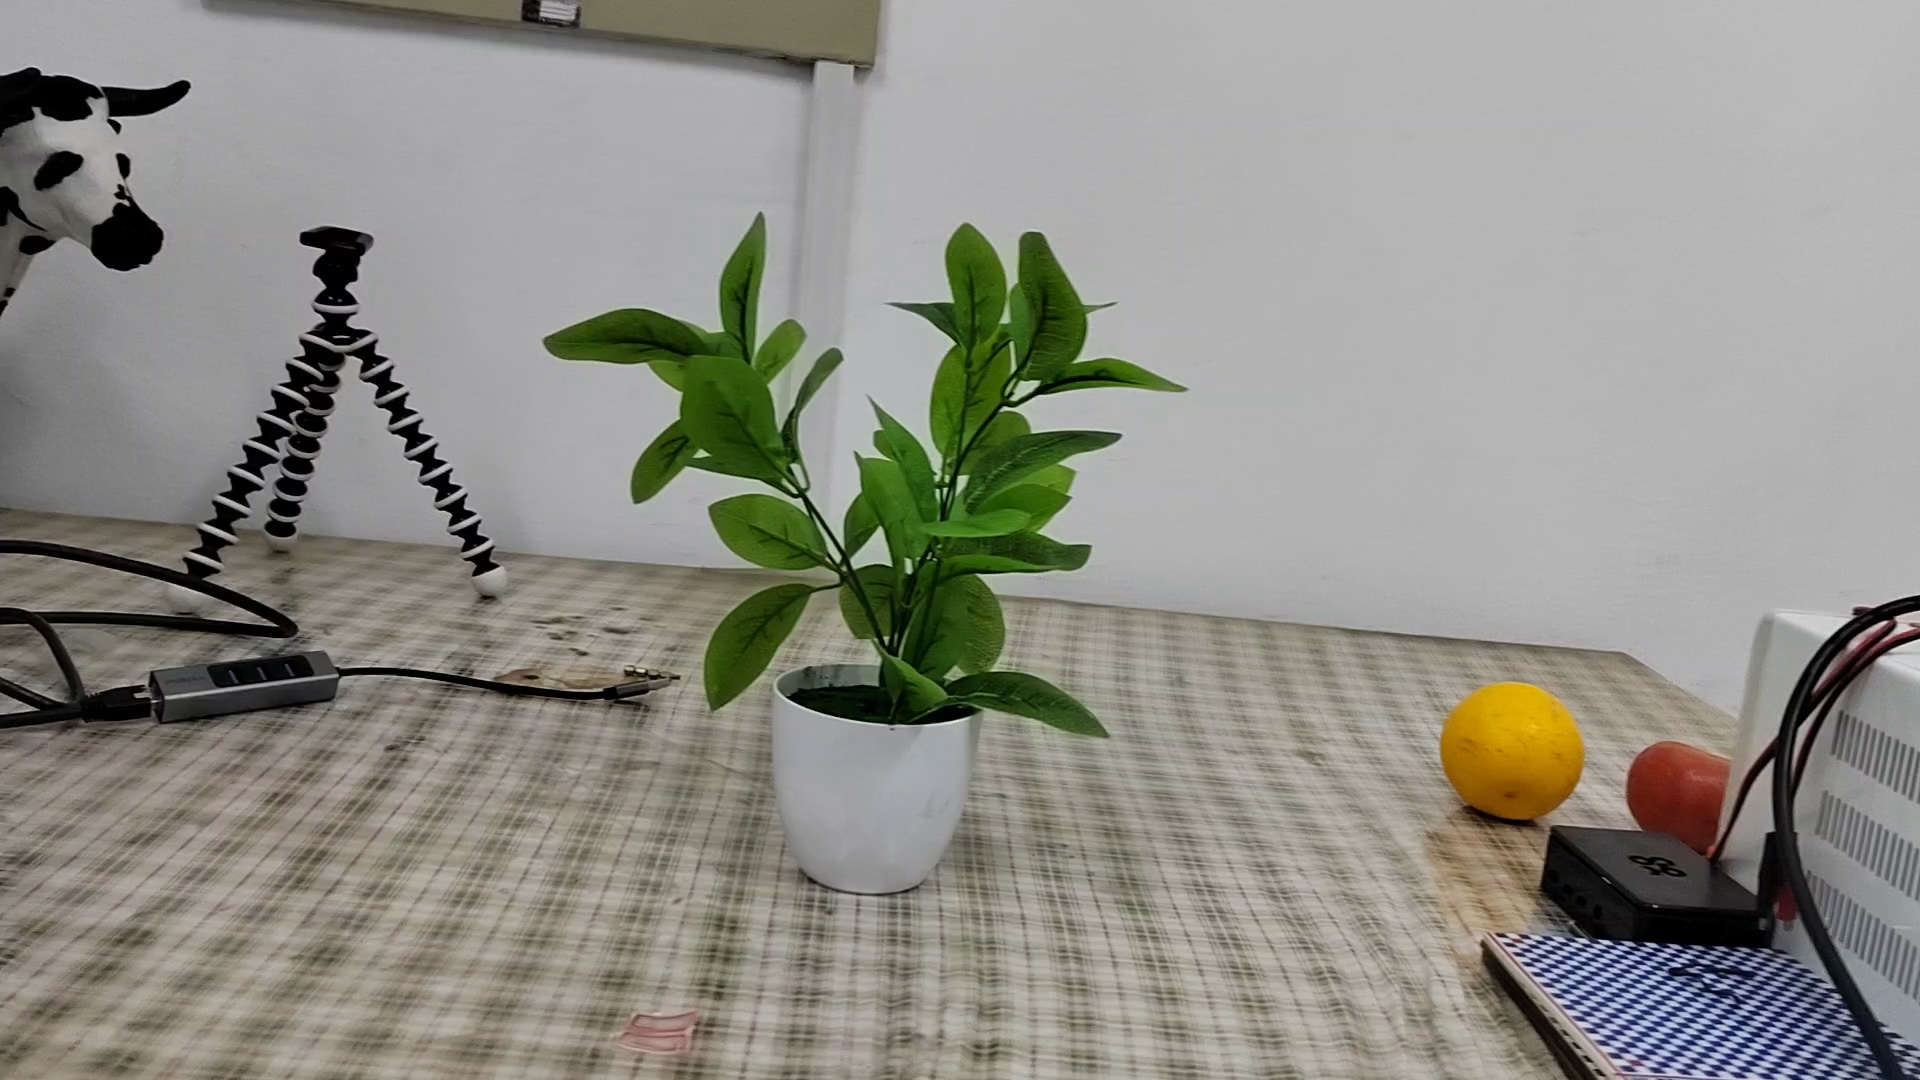

In [ ]:
from google.colab.patches import cv2_imshow
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
import cv2

# 读取测试图像
im = cv2.imread("./3.jpg")
cv2_imshow(im)

In [ ]:
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.engine.defaults import DefaultPredictor

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))  # 使用之前训练的配置文件
cfg.MODEL.WEIGHTS = "./output/plant_object_fpn_R_50_1x_100/model_final.pth"  # 使用之前训练得到的模型权重文件

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[09/05 08:39:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/plant_object_fpn_R_50_1x_100/model_final.pth ...


In [ ]:
print(outputs["instances"].pred_boxes)

Boxes(tensor([[ 604.0034,  158.7758, 1202.4604,  863.9944]], device='cuda:0'))


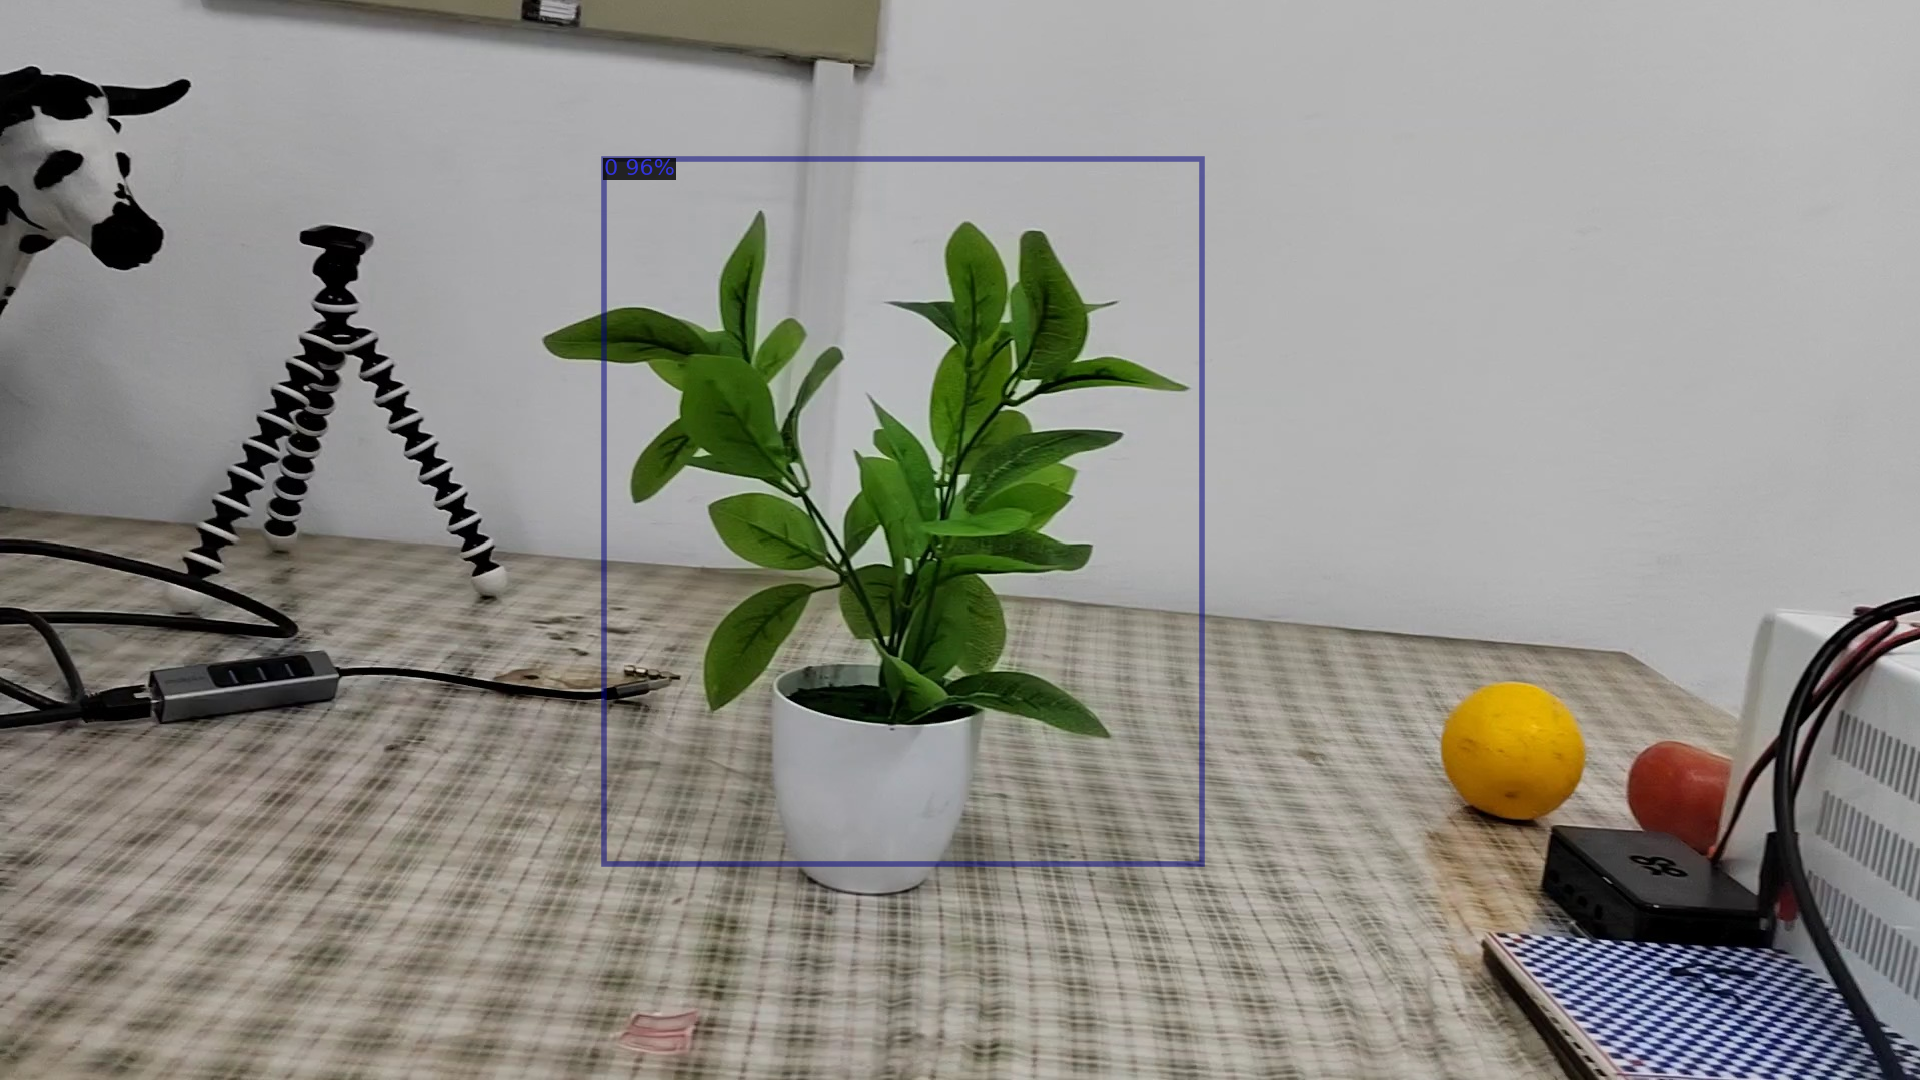

In [ ]:
# 创建自定义的 MetadataCatalog
my_metadata = MetadataCatalog.get("my_dataset")
my_metadata.set(thing_classes=["plant"])  # 设置自定义的类别名称列表

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], my_metadata, scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
out_frame=out.get_image()[:, :, ::-1]
cv2_imshow(out_frame)

## 预测视频

In [ ]:
from google.colab.patches import cv2_imshow
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine.defaults import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
import cv2

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))  # 使用之前训练的配置文件
cfg.MODEL.WEIGHTS = "./output/plant_object/model_final.pth"  # 使用之前训练得到的模型权重文件

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

predictor = DefaultPredictor(cfg)

In [ ]:
video_path = "plant1.mp4"  # 替换为输入视频文件的路径
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

In [ ]:
# 创建输出视频文件
output_path = "plant_output.mp4"  # 替换为输出视频文件的路径
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 使用 MP4 编码器
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

In [ ]:
# 创建自定义的 MetadataCatalog
my_metadata = MetadataCatalog.get("my_dataset")
my_metadata.set(thing_classes=["plant"])  # 设置自定义的类别名称列表

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    predictions = predictor(frame)
    instances = predictions["instances"].to("cpu")
    visualizer = Visualizer(frame[:, :, ::-1], my_metadata, scale=1.0)
    out_frame = visualizer.draw_instance_predictions(predictions["instances"].to("cpu")).get_image()[:, :, ::-1]

    # 判断bbox中心是否在图像横轴中间
    for bbox in instances.pred_boxes:
        x_center = (bbox[0] + bbox[2]) / 2
        if frame_width * 7 / 15 < x_center < frame_width * 8 / 15:
            out.write(out_frame)
            cv2.imwrite("./stop.jpg",out_frame)
            break  # 保存满足条件的帧并继续下一帧
        else:
          out.write(out_frame)

cap.release()
out.release()
cv2.destroyAllWindows()